After implementing deep learning algorithm (only fully-connected layers introduced) and data augmentation, now let's try whether CNN could give us better output or not.

## LeNet-5 Structure

    input: 28 * 28 images
    zeropadding: (2, 2) => 32 * 32
    conv_1: 5 * 5 and 6 filters => 28 * 28 * 6
    act_1: activation
    avgpool_2: 2 * 2 and non-overlapping => 14 * 14 * 6
    conv_3: 5 * 5 and 16 filters => 10 * 10 * 16
    act_2: activation
    avgpool_4: 2 * 2 and non-overlapping => 5 * 5 * 16
    conv_5: 5 * 5 and 120 filters => fully-connected 120 * 1
    act_3: activation
    fc_6: fully-connected 84 * 1
    act_4: activation
    output_layer(act_4): 10 * 1
    
    Note: not implementing bias in conv

In [2]:
import warnings
warnings.filterwarnings('ignore')

#import necessary modules
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.python.framework import ops

%matplotlib inline

## 1 Preparing the data (Preprocessing)
### 1.1 Loading datasets

In [3]:
#read training and test sets
data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [4]:
#set features and labels (arrays)
features = data.iloc[:, 1:].values.reshape((42000,28,28,1))
labels = data.iloc[:, 0].values.reshape((42000,1))
test = test.values.reshape((28000,28,28,1))

### 1.2 Zero-padding to 32 * 32

In [5]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
    X_pad = np.pad(X, ((0,0), (pad,pad), (pad,pad), (0,0)), 'constant', constant_values = (0,0))
    
    return X_pad

In [6]:
features = zero_pad(features, 2)
test = zero_pad(test, 2)
features.shape

(42000, 32, 32, 1)

### 1.3 Split training and test set

In [7]:
#train test split
X_train, X_test, Y_train, Y_test = train_test_split(features,
                                                   labels,
                                                   test_size = 0.025,
                                                   random_state = 0,
                                                   stratify = labels)
#no dev needed

In [8]:
test.shape

(28000, 32, 32, 1)

### 1.4 Normalizing inputs and one-hot-coding labels

In [9]:
#Normalize image inputs
def feature_norm(x):
    '''
    Normalize the feature values of x
    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    X_norm -- normalized x
    '''
    X_norm = x / 255
    return X_norm

X_train, X_test = feature_norm(X_train), feature_norm(X_test)

In [10]:
#One-hot-code y values
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

Y_train, Y_test = convert_to_one_hot(Y_train, 10), convert_to_one_hot(Y_test, 10)

(<matplotlib.image.AxesImage at 0x105eded68>,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 (40950, 10))

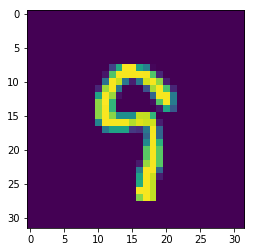

In [11]:
plt.imshow(X_train[10].reshape((32,32))), Y_train[10], Y_train.shape

## 2 Build forward propagation
### 2.1 Loading input matrix, creating input layer

In [12]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder(tf.float32, shape = (None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32, shape = (None, n_y))
    
    return X, Y

In [13]:
X, Y = create_placeholders(32, 32, 1, 10)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 32, 32, 1), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 10), dtype=float32)


### 2.2 Setting conv parameter matrix

In [14]:
def initialize_parameters(C_F1 = 6, C_F3 = 16):
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        C_W1 : [5, 5, 1, 16]
                        C_W3 : [5, 5, 6, 32]
                        C_W5 : [5, 5, 16, 120]
                        FC => shape    [1, 120]
                        FC_W6: [120, 84]
                        FC_W7: [84, 10]
                        
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    C_W1 = tf.get_variable("C_W1", [5, 5, 1, C_F1], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    C_W3 = tf.get_variable("C_W3", [5, 5, C_F1, C_F3], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    C_W5 = tf.get_variable("C_W5", [5, 5, C_F3, 120], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    FC_W6 = tf.get_variable("FC_W6", [120, 84], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    bias_6 = tf.Variable(tf.zeros([84]))
    FC_W7 = tf.get_variable("FC_W7", [84, 10], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    bias_7 = tf.Variable(tf.zeros([10]))

    parameters = {"C_W1": C_W1,
                  "C_W3": C_W3,
                  "C_W5": C_W5,
                  "FC_W6": FC_W6,
                  "bias_6": bias_6,
                  "FC_W7": FC_W7,
                  "bias_7": bias_7}
    
    return parameters

### 2.2 Building forward propagation process

When implementing conv2d, there's no need to set bias variables bcz the function sets bias computation automatically.
    
    conv2d(
        use_bias=True,
        bias_initializer=tf.zeros_initializer())

In [15]:
def forward_propagation(X, parameters, pooling = 'max'):
    """
    Implements the forward propagation for the model:
    CONV2D_1 -> RELU -> MAX/AVGPOOL_2 -> CONV2D_3 -> RELU -> MAX/AVGPOOL_4 -> CONV2D_5 -> RELU -> FLATTEN -> 
    FULLYCONNECTED_6 -> FULLYCONNECTED_7
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z7 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    C_W1 = parameters['C_W1']
    C_W3 = parameters['C_W3']
    C_W5 = parameters['C_W5']
    FC_W6 = parameters['FC_W6']
    bias_6 = parameters['bias_6']
    FC_W7 = parameters['FC_W7']
    bias_7 = parameters['bias_7']
    
    # CONV2D: filters C_W1, stride of 1, padding 'SAME'
    conv_1 = tf.nn.conv2d(X, C_W1, strides = [1,1,1,1], padding = 'VALID') #[m,h,w,c]
    #print(conv_1)
    
    # padding arguement refer to 
    # https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t
    # RELU
    A1 = tf.nn.relu(conv_1)

    if pooling == 'max':
        # MAXPOOL: window 2x2, stride 2, padding 'SAME'
        maxpool_2 = tf.nn.max_pool(A1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
        #print(maxpool_2)
    
        # CONV2D: filters C_W3, stride 1, padding 'SAME'
        conv_3 = tf.nn.conv2d(maxpool_2, C_W3, strides = [1,1,1,1], padding = 'VALID')
        #print(conv_3)
    
        # RELU
        A2 = tf.nn.relu(conv_3)
        # MAXPOOL: window 2x2, stride 2, padding 'SAME'
        maxpool_4 = tf.nn.max_pool(A2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
        #print(maxpool_4)
    
        # CONV2D: filters C_W5, stride 1, padding 'SAME'
        conv_5 = tf.nn.conv2d(maxpool_4, C_W5, strides = [1,1,1,1], padding = 'VALID')
        #print(conv_5)
        
    elif pooling == 'avg':
        # AVGPOOL: window 2x2, stride 2, padding 'SAME'
        avgpool_2 = tf.nn.avg_pool(A1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
        #print(maxpool_2)
    
        # CONV2D: filters C_W3, stride 1, padding 'SAME'
        conv_3 = tf.nn.conv2d(avgpool_2, C_W3, strides = [1,1,1,1], padding = 'VALID')
        #print(conv_3)
    
        # RELU
        A2 = tf.nn.relu(conv_3)
        # AVGPOOL: window 2x2, stride 2, padding 'SAME'
        avgpool_4 = tf.nn.avg_pool(A2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
        #print(maxpool_4)
    
        # CONV2D: filters C_W5, stride 1, padding 'SAME'
        conv_5 = tf.nn.conv2d(avgpool_4, C_W5, strides = [1,1,1,1], padding = 'VALID')
        #print(conv_5)
    
    # RELU
    A3 = tf.nn.relu(conv_5)
    # FLATTEN
    fc_5 = tf.reshape(A3, [-1, 120]) #output: [batch_size, k]
    # FULLY-CONNECTED
    fc_6 = tf.nn.bias_add(tf.matmul(fc_5, FC_W6), bias_6)
    # RELU
    A4 = tf.nn.relu(fc_6)
    # FULLY-CONNECTED without non-linear activation function (not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    fc_7 = tf.nn.bias_add(tf.matmul(A4, FC_W7), bias_7)
    ### END CODE HERE ###

    return fc_7

### 2.3 Build cost function

In [16]:
# GRADED FUNCTION: compute_cost 

def compute_cost(fc_7, Y):
    """
    Computes the cost
    
    Arguments:
    fc_7 -- output of forward propagation (output of the last LINEAR unit), of shape (number of examples, 10)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = fc_7, labels = Y)) #squeeze and compute mean
    
    return cost

## 3 Run CNN
### 3.1 Build model

In [17]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [18]:
def model(X_train, Y_train, X_test, Y_test, test, learning_rate = 0.0005,
          num_epochs = 30, minibatch_size = 64, pooling = 'max',
          C_F1 = 6, C_F3 = 16,
          print_cost = True, learning_decay = False):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D_1 -> RELU -> MAXPOOL_2 -> CONV2D_3 -> RELU -> MAXPOOL_4 -> CONV2D_5 -> RELU -> FLATTEN -> 
    FULLYCONNECTED_6 -> FULLYCONNECTED_7
    
    Arguments:
    X_train -- training set, of shape (None, 28, 28, 1)
    Y_train -- test set, of shape (None, n_y = 10)
    X_test -- training set, of shape (None, 28, 28, 1)
    Y_test -- test set, of shape (None, n_y = 10)
    test -- the test set (to be predicted), of shape (None, 28, 28, 1)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    pooling -- pooling method, avg or max
    C_F1 -- filters number in conv_1
    C_F3 -- filters number in conv_3
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(5)                             # to keep results consistent (tensorflow seed)
    seed = 7                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initialize parameters
    parameters = initialize_parameters(C_F1 = C_F1, C_F3 = C_F3)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    fc_7 = forward_propagation(X, parameters, pooling = pooling)
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(fc_7, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                #print(temp_cost)
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0 and epoch / 5 > 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
                if learning_decay:
                    learning_rate /= 2
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(fc_7, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
        
        #output the prediction for kaggle
        predicted_labels = np.zeros(test.shape[0])
        predicted_labels = sess.run(predict_op, 
                                    feed_dict={X: test})
                
        return train_accuracy, test_accuracy, parameters, predicted_labels

Cost after epoch 5: 0.182135
Cost after epoch 10: 0.099705
Cost after epoch 15: 0.068575
Cost after epoch 20: 0.049650
Cost after epoch 25: 0.038744


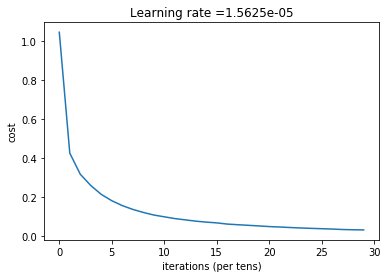

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.98849815
Test Accuracy: 0.9847619


In [181]:
_, _, parameters, predicted_labels = model(X_train, Y_train, X_test, Y_test, test, 
                                          learning_rate = 0.0005, mini_batch = 64,
                                          learning_decay = True)

In [183]:
submissions = pd.DataFrame({'ImageId': np.arange(1 , 1 + test.shape[0]), 'Label': predicted_labels.astype(int)})
submissions.to_csv('./tf_CNN.csv', index=False)
#0.98642

## 4 Other tries
### 4.1 Average pooling

Cost after epoch 5: 0.232350
Cost after epoch 10: 0.133657
Cost after epoch 15: 0.091462
Cost after epoch 20: 0.066840
Cost after epoch 25: 0.051330
Cost after epoch 30: 0.040982


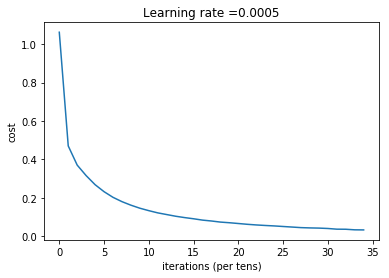

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.99084246
Test Accuracy: 0.9809524


In [186]:
_, _, parameters, predicted_labels = model(X_train, Y_train, X_test, Y_test, test, learning_rate = 0.0005,
                                          num_epochs = 35, minibatch_size = 64, pooling = 'avg',
                                          print_cost = True, learning_decay = False)

In [187]:
submissions = pd.DataFrame({'ImageId': np.arange(1 , 1 + test.shape[0]), 'Label': predicted_labels.astype(int)})
submissions.to_csv('./tf_CNN(avg).csv', index=False)
#0.98271

### 4.2 Run CNN with more filters

Cost after epoch 5: 0.026192
Cost after epoch 10: 0.011192
Cost after epoch 15: 0.006846
Cost after epoch 20: 0.004390
Cost after epoch 25: 0.002752


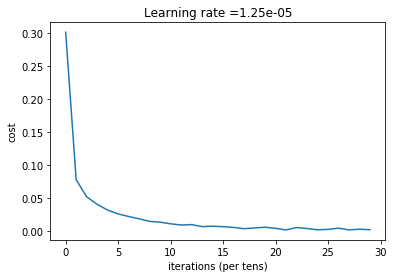

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.9983394
Test Accuracy: 0.9895238


In [38]:
_, _, parameters, predicted_labels = model(X_train, Y_train, X_test, Y_test, test, learning_rate = 0.0004,
                                          num_epochs = 30, minibatch_size = 64, pooling = 'max',
                                          C_F1 = 16, C_F3 = 64,
                                          print_cost = True, learning_decay = True)

In [39]:
submissions = pd.DataFrame({'ImageId': np.arange(1 , 1 + test.shape[0]), 'Label': predicted_labels.astype(int)})
submissions.to_csv('./tf_CNN(more_filters).csv', index=False)
#0.99028

### 4.3 Data Augmentation

In [19]:
#read new data
new_data = pd.read_csv('data/new_image_data.csv', index_col = False)
new_data.columns = data.columns

data = data.append(new_data, ignore_index = True)

#split features and labels
features = data.iloc[:, 1:].values.reshape((-1,28,28,1))
labels = data.iloc[:, 0].values.reshape((-1,1))

#zero padding
features = zero_pad(features, 2)

(61999, 32, 32, 1)


In [21]:
#train test split
X_train, X_test, Y_train, Y_test = train_test_split(features,
                                                   labels,
                                                   test_size = 0.02,
                                                   random_state = 0,
                                                   stratify = labels)
#print(X_train.shape)

Y_train, Y_test = convert_to_one_hot(Y_train, 10), convert_to_one_hot(Y_test, 10)
X_train, X_test = feature_norm(X_train), feature_norm(X_test)

In [22]:
#check
Y_train.shape, Y_test.shape, X_train.shape, X_test.shape, test.shape

((60759, 10),
 (1240, 10),
 (60759, 32, 32, 1),
 (1240, 32, 32, 1),
 (28000, 32, 32, 1))

Cost after epoch 5: 0.018276
Cost after epoch 10: 0.006792
Cost after epoch 15: 0.005457
Cost after epoch 20: 0.003182
Cost after epoch 25: 0.002375


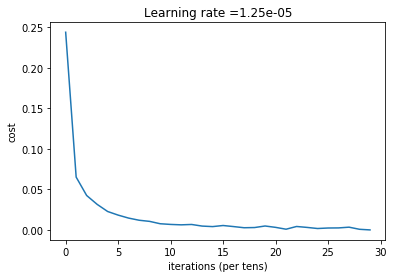

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 1.0
Test Accuracy: 0.9967742


In [23]:
_, _, parameters, predicted_labels = model(X_train, Y_train, X_test, Y_test, test, learning_rate = 0.0004,
                                          num_epochs = 30, minibatch_size = 64, pooling = 'max',
                                          C_F1 = 32, C_F3 = 64,
                                          print_cost = True, learning_decay = True)

In [24]:
submissions = pd.DataFrame({'ImageId': np.arange(1 , 1 + test.shape[0]), 'Label': predicted_labels.astype(int)})
submissions.to_csv('./tf_CNN(data_aug).csv', index=False)

#### References:
Deep learning from Andrew Ng: Convolution model Application

https://github.com/woodyko3234/Deep-Learning-Coursera/blob/master/Convolutional%20Neural%20Networks/Week1%20-%20CNN%20Basics/Convolution%20model%20-%20Application%20-%20v1.ipynb

Deep learning from Andrew Ng: Keras Tutorial - Happy House

https://github.com/woodyko3234/Deep-Learning-Coursera/blob/master/Convolutional%20Neural%20Networks/Week2%20-%20CNN%20Architectures/Keras%20Tutorial%20-%20Happy%20House%20v2.ipynb

LeNet-5 by Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner.

http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf